# Assignment IX: Sentiment Analysis Using Deep Learning

## Question 1

Build a movie review classifier using the dataset in `demo_data/movie_reviews.csv`. The objective of the classifier is to automatically classify a movie review into either positive or negative category.

The dataset is the famous IMBd moview reviews dataset. You can take a look at the SOTA classification performance on this dataset [here](https://paperswithcode.com/sota/sentiment-analysis-on-imdb).

In your experiments, please include the following strategies in your considerations:

- Please use sequence models for this task (you may experiment with networks of different topologies).
- For embedding layers, please try both self-trained embedding layer along with the sentiment classifier, as well as pre-trained embeddings (either provided in `spacy`, or available on [GloVe](https://nlp.stanford.edu/projects/glove/) website).
- Please include dropout and regularization layers to avoid overfitting.

- This tutorial uses Sarkar's book example.
- Simple Multilayer Deep Neural Network on Sentiment Classification
- Use the average text embeddings based on word embeddings
- Use both self-trained word embeddings and spacy embeddings.

In [45]:
%%time

## loading packages

import pandas as pd
import numpy as np
import nltk
import gensim
import tensorflow
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization

np.set_printoptions(precision=2, linewidth=80)

CPU times: user 1.17 ms, sys: 2.15 ms, total: 3.32 ms
Wall time: 83.8 ms


In [38]:
print(tensorflow.__version__)

## Loading the raw data and look at the structure of the data quickly
dataset = pd.read_csv('../../../RepositoryData/data/movie_reviews.csv')

# take a peek at the data
print(dataset.head())

## split reviews and sentiments
reviews = np.array(dataset['review'])
sentiments = np.array([0 if l=="negative" else 1 for l in dataset['sentiment']])

print(reviews.shape)
print(sentiments.shape)

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

2.4.1
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000,)
(50000,)


In [4]:
import TAWP
import re
from TAWP.contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    ## create a regex pattern of all contracted forms
    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)  # the whole matched contraction

        # if the matched contraction (=keys) exists in the dict,
        # get its corresponding uncontracted form (=values)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())

        return expanded_contraction

    # find each contraction in the pattern,
    # find it from text,
    # and replace it using the output of
    # expand_match
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [5]:
def normalize(text):
    text = expand_contractions(text)
    text = re.sub(r'<.+?>',"", text)
    text = re.sub(r'\s+',' ', text)
    return text
    
normalize_corpus = np.vectorize(normalize)

In [6]:
print(train_reviews[101])

Okay, last night, August 18th, 2004, I had the distinct displeasure of meeting Mr. Van Bebble at a showing of the film The Manson Family at the Three Penny in Chicago as part of the Chicago Underground Film Festival. Here's what I have to say about it. First of all, the film is an obvious rip off of every Kenneth Anger, Roman Polanski, Oliver Stone and Terry Gilliam movie I've ever seen. Second of all, in a short Q & A session after the show Mr. Van Bebble immediately stated that he never made any contact with the actual Manson Family members or Charlie himself, calling them liars and saying he wanted nothing to do with them, that the film was based on his (Van Bebble's) take on the trial having seen it all from his living room on TV and in the news (and I'm assuming from the Autobiography and the book Helter Skelter which were directly mimicked through the narrative). So I had second dibs on questions, I asked if he was trying to present the outsider, Mtv, sex drugs and rock 'n roll v

In [7]:
print(normalize_corpus(train_reviews[1]))

A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great masters of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional dream techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwells murals decorating every surface) are terribly well done.


In [8]:
%%time
## Processing is ignored
norm_train_reviews = normalize_corpus(train_reviews)
norm_test_reviews = normalize_corpus(test_reviews)

CPU times: user 1min 46s, sys: 979 ms, total: 1min 47s
Wall time: 1min 49s


In [62]:
NUM_WORDS = 10000

tokenizer=Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(train_reviews)

# vocab_size = len(tokenizer.word_index) + 1
VOCAB_SIZE = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [51]:
list(tokenizer.word_index.items())[:10]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('br', 7),
 ('in', 8),
 ('it', 9),
 ('i', 10)]

In [59]:
def reviews_to_sequences(reviews, MAX_LEN = 200):
    reviews_int = tokenizer.texts_to_sequences(reviews)
    reviews_pad = sequence.pad_sequences(reviews_int,
                           maxlen = MAX_LEN, 
                           truncating='pre', 
                           padding='pre')
    return np.array(reviews_pad).astype('float32')


X_train = reviews_to_sequences(train_reviews)
X_test = reviews_to_sequences(test_reviews)
y_train = keras.utils.to_categorical(train_sentiments, num_classes) ## sequences to one-hot
y_test = keras.utils.to_categorical(test_sentiments, num_classes) ## sequences to one-hot


In [73]:
print(X_train.shape)
print(y_train[:10])

(35000, 200)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [92]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot1(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [82]:
def build_model_lstm():
    model = Sequential()
#     model.add(Input(shape=(MAX_LEN,)))
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation="softmax"))
    return model
def build_model_lstm_pretrained_emb(train_emb=False):
    model = Sequential()
#     model.add(Input(shape=(MAX_LEN,)))

    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True,
                        weights=[embedding_matrix], trainable=train_emb))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation="softmax"))
    return model

def build_model_bilstm_pretrain_emb(train_emb=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, 
                       weights=[embedding_matrix], trainable=train_emb))
    model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=True, dropout=0.5)))
    model.add(Bidirectional(LSTM(LSTM_DIM, dropout=0.25)))
    model.add(Dense(2, activation="softmax"))
    return model

In [60]:
### Using Spacy embeddings

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'tag','entity'])

In [64]:
w2id = tokenizer.word_index
id2w = {id:w for (w,id) in w2id.items()}

In [65]:
## initialize word embedding matrix
EMBED_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
embedding_matrix.shape
unk_cnt = 0
unk_set = set()
len(w2id)
spacy_w2v = {}
spacy_w2v = {nlp.vocab.strings[wid]:wvec for (wid, wvec) in nlp.vocab.vectors.items()}

In [66]:
spacy_w2v['the'][:10]

array([ 0.27, -0.06, -0.19,  0.02, -0.02,  0.01, -0.14,  0.18,  0.18,  2.59],
      dtype=float32)

In [67]:
nlp('the').vector[:10]

array([ 0.27, -0.06, -0.19,  0.02, -0.02,  0.01, -0.14,  0.18,  0.18,  2.59],
      dtype=float32)

In [68]:
%%time
unk_cnt = 0
unk_set = set()

for word in list(w2id.keys())[:10000]:
    cur_word_vec = spacy_w2v.get(word)
    
    if cur_word_vec is not None:
        cur_word_id = w2id[word]
        embedding_matrix[cur_word_id]=cur_word_vec

    else:
        unk_cnt +=1
        unk_set.add(word)
print("Total Unkown Words in IMDB:", unk_cnt)

Total Unkown Words in IMDB: 195
CPU times: user 30.2 ms, sys: 8.25 ms, total: 38.4 ms
Wall time: 37.4 ms


In [ ]:
## Using GloVe Embeddings

In [87]:
glove_file = "../../../RepositoryData/data/glove/glove.6B/glove.6B.50d.txt"
glove_w2v = {}
with open(glove_file,'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        
        if vector.shape[0]==50:
            glove_w2v[word] = vector
        else:
            print("There was an issue with " + word)

print(len(glove_w2v))

400000


In [89]:
%%time
## initialize word embedding matrix
EMBED_DIM = 50
embedding_matrix_glove = np.zeros((VOCAB_SIZE, EMBED_DIM))
embedding_matrix_glove.shape
unk_cnt = 0
unk_set = set()

for word in list(w2id.keys())[:10000]:
    cur_word_vec = glove_w2v.get(word)
    
    if cur_word_vec is not None:
        cur_word_id = w2id[word]
        embedding_matrix_glove[cur_word_id]=cur_word_vec

    else:
        unk_cnt +=1
        unk_set.add(word)
print("Total Unkown Words in IMDB (GloVe):", unk_cnt)

Total Unkown Words in IMDB (GloVe): 184
CPU times: user 22.1 ms, sys: 2.23 ms, total: 24.3 ms
Wall time: 22.4 ms


In [83]:
## Model Building

from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, Input, Bidirectional, LSTM

LSTM_DIM = 64 # total LSTM units
model1 = build_model_lstm()
model2_1 = build_model_lstm_pretrained_emb(train_emb=False)
model2_2 = build_model_lstm_pretrained_emb(train_emb=True)
model3_1 = build_model_bilstm_pretrain_emb(train_emb=False)
model3_2 = build_model_bilstm_pretrain_emb(train_emb=True)

model1.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model2_1.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model2_2.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model3_1.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])
model3_2.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy", "Precision", "Recall"])

In [75]:
EPOCH= 10
BATCH_SIZE = 256

In [81]:
print(X_train.shape)
print(y_train.shape)

(35000, 200)
(35000, 2)


In [84]:
## Model fitting
history1 = model1.fit(X_train, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)

Epoch 1/10
110/110 [==============================] - 108s 950ms/step - loss: 0.5505 - accuracy: 0.6854 - precision: 0.6854 - recall: 0.6854 - val_loss: 0.2941 - val_accuracy: 0.8789 - val_precision: 0.8789 - val_recall: 0.8789
Epoch 2/10
110/110 [==============================] - 94s 856ms/step - loss: 0.2328 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - val_loss: 0.2995 - val_accuracy: 0.8806 - val_precision: 0.8806 - val_recall: 0.8806
Epoch 3/10
110/110 [==============================] - 93s 847ms/step - loss: 0.1613 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - val_loss: 0.3269 - val_accuracy: 0.8761 - val_precision: 0.8761 - val_recall: 0.8761
Epoch 4/10
110/110 [==============================] - 97s 879ms/step - loss: 0.1191 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - val_loss: 0.3472 - val_accuracy: 0.8687 - val_precision: 0.8687 - val_recall: 0.8687
Epoch 5/10
110/110 [==============================] - 100s 906ms/step - loss: 0.0961 - accu

In [85]:
## Model fitting
history2_1 = model2_1.fit(X_train, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)
## Model fitting
history2_2 = model2_2.fit(X_train, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)
## Model fitting
history3_1 = model3_1.fit(X_train, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)
## Model fitting
history3_2 = model3_2.fit(X_train, y_train,
                   epochs=EPOCH,
                   batch_size= BATCH_SIZE,
                   validation_split=0.2)

Epoch 1/10
110/110 [==============================] - 72s 631ms/step - loss: 0.5914 - accuracy: 0.6749 - precision: 0.6749 - recall: 0.6749 - val_loss: 0.4497 - val_accuracy: 0.8114 - val_precision: 0.8114 - val_recall: 0.8114
Epoch 2/10
110/110 [==============================] - 69s 624ms/step - loss: 0.4381 - accuracy: 0.8005 - precision: 0.8005 - recall: 0.8005 - val_loss: 0.3674 - val_accuracy: 0.8436 - val_precision: 0.8436 - val_recall: 0.8436
Epoch 3/10
110/110 [==============================] - 67s 605ms/step - loss: 0.4047 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - val_loss: 0.4159 - val_accuracy: 0.8387 - val_precision: 0.8387 - val_recall: 0.8387
Epoch 4/10
110/110 [==============================] - 67s 613ms/step - loss: 0.3609 - accuracy: 0.8424 - precision: 0.8424 - recall: 0.8424 - val_loss: 0.3186 - val_accuracy: 0.8666 - val_precision: 0.8666 - val_recall: 0.8666
Epoch 5/10
110/110 [==============================] - 70s 633ms/step - loss: 0.3333 - accura

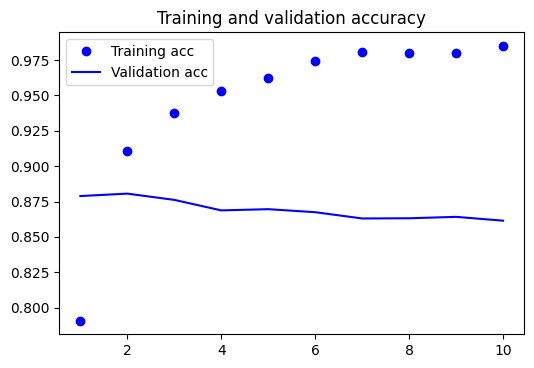

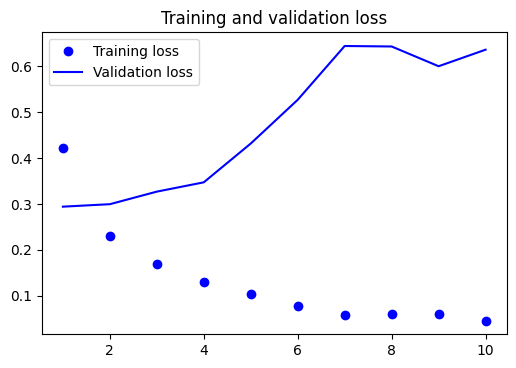

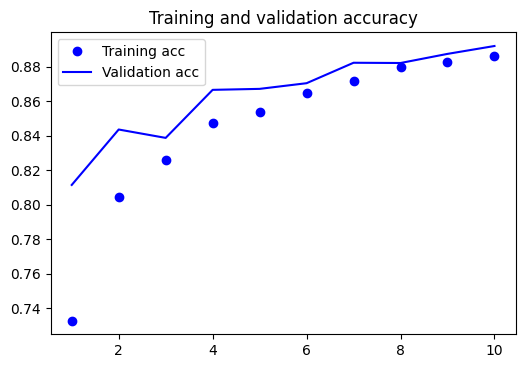

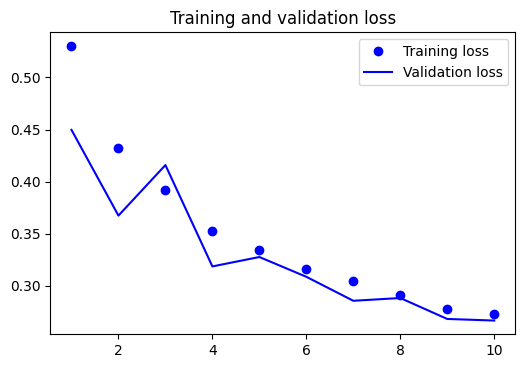

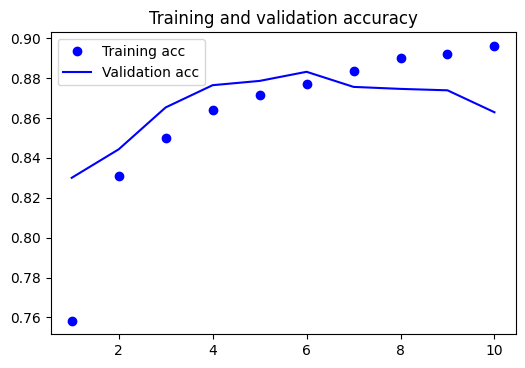

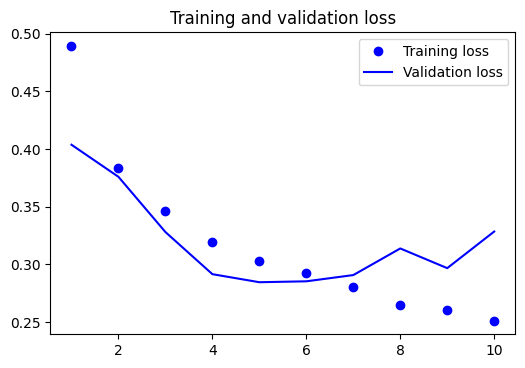

In [96]:
plot1(history1)
plot1(history2_1)
plot1(history3_1)

### Not Used


The following codes are from Sarkar's book. I am not going to use the following codes.

In [9]:
# from nltk.tokenize.toktok import ToktokTokenizer

# tokenizer = ToktokTokenizer()

# # tokenize train reviews & encode train labels
# tokenized_train = [tokenizer.tokenize(text)
#                    for text in norm_train_reviews]

In [40]:

## Convert sentiments into one-hot encodings
## labels to integers to one-hot
#le = LabelEncoder() ## label to sequences
#num_classes=2 
#y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(train_sentiments, num_classes) ## sequences to one-hot

#print(y_tr[:5])
print(y_train[:5])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [41]:
# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in norm_test_reviews]

#y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(test_sentiments, num_classes)



# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: [0 1 0] 
Encoded Labels: [0 1 0] 
One hot encoded Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


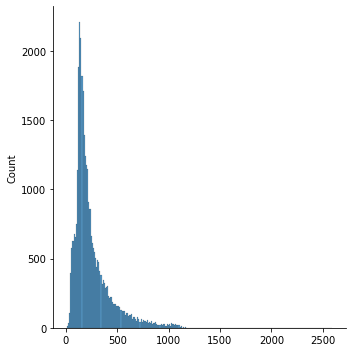

In [12]:
tokenized_train_len = [len(text) for text in tokenized_train]
import seaborn as sns
sns.displot(tokenized_train_len)

In [13]:
## min and max text lengths in training set
print(np.amin(tokenized_train_len))
print(np.amax(tokenized_train_len))

8
2594


## Training Word Embeddings

- Training the word embeddings using skip-gram on the training set
- Compute the average of embeddings for each document in the training and testing set

In [14]:
%%time
# build word2vec model
embed_dim = 96
w2v_model = gensim.models.Word2Vec(tokenized_train,
                                   size=embed_dim,
                                   window=5,
                                   max_vocab_size=20000,
                                   min_count=10,
                                   sample=1e-3,
                                   workers=4,
                                   sg=0)  # `sg=0` for BOW; `sg=1` for skipgram

## takes 5mins

CPU times: user 50.1 s, sys: 408 ms, total: 50.5 s
Wall time: 16.9 s


In [15]:
## This model uses the document word vector averaging scheme
## Use the average word vector representations to represent one document (movie reivew)

def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector
    
    # For each text in the corpus
    # Find the embeddings of each word in the corpus
    # and add all word vectors together and take the average
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [16]:
%%time
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=embed_dim)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=embed_dim)

CPU times: user 54.7 s, sys: 605 ms, total: 55.3 s
Wall time: 55.4 s


## Loading Pre-trained Word Embeddings

- Load the GloVe embeddings from `spacy`. (The embedding dimension size of the small language model is 96).
- `spacy` computes the average embeddings for each document.

In [17]:
%%time
# Use the N-dimensional word vectors trained on the Common Crawl using the GloVe model
# Provided by spaCy

import spacy
#nlp = spacy.load('en', parse=False, tag=False, entity=False)
nlp_vec = spacy.load('en_core_web_sm', disable=['parser', 'tag','entity'])

CPU times: user 1.87 s, sys: 428 ms, total: 2.3 s
Wall time: 28.6 s


- spacy will automatically compute the average embeddings for the document.

In [18]:
doc =nlp_vec(str(norm_train_reviews[0]))
doc.vector

array([ 0.18,  0.04,  0.03, -0.11,  0.1 ,  0.11, -0.09,  0.09,  0.19, -0.28,
       -0.04, -0.  , -0.18, -0.08,  0.01,  0.04,  0.09, -0.17,  0.15,  0.  ,
       -0.12,  0.16,  0.08,  0.09, -0.3 , -0.02, -0.08,  0.22,  0.05,  0.25,
       -0.17,  0.01,  0.06, -0.27,  0.24, -0.06,  0.23, -0.07,  0.04,  0.17,
        0.01, -0.06, -0.01, -0.03, -0.02, -0.12,  0.1 ,  0.03, -0.07, -0.03,
        0.26,  0.02, -0.22, -0.17,  0.03,  0.15,  0.13,  0.04,  0.16,  0.14,
       -0.04, -0.2 , -0.06, -0.06,  0.1 , -0.09, -0.07, -0.19,  0.05,  0.15,
        0.19, -0.06,  0.04, -0.17, -0.17, -0.03, -0.15, -0.19, -0.09, -0.02,
       -0.03,  0.22,  0.16,  0.06, -0.07, -0.16, -0.14, -0.25, -0.15, -0.25,
       -0.16,  0.12,  0.18,  0.07,  0.14, -0.1 ], dtype=float32)

In [19]:
%%time

train_docs = nlp_vec.pipe([str(item) for item in norm_train_reviews], n_process=4)
train_glove_features = np.array([doc.vector for doc in train_docs])

CPU times: user 1min 57s, sys: 29 s, total: 2min 26s
Wall time: 5min 34s


In [20]:
%%time

test_docs = nlp_vec.pipe([str(item) for item in norm_test_reviews], n_process=4)
test_glove_features = np.array([doc.vector for doc in test_docs])

CPU times: user 48.7 s, sys: 17.6 s, total: 1min 6s
Wall time: 2min 28s


In [21]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (35000, 96)  Test features shape: (15000, 96)
GloVe model:> Train features shape: (35000, 96)  Test features shape: (15000, 96)


## Building Model

- A simple fully-connected 4 layer deep neural network
    - input layer (not counted as one layer), i.e., the word embedding layer
    - three dense hidden layers (with 512 neurons)
    - one output layer (with 2 neurons for classification)
- (aka. multi-layered perceptron or deep ANN)

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [23]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # improve  stability of the network.
    dnn_model.add(Activation('relu')) # relu better than sigmoid, to present vanishing gradient problem
    dnn_model.add(Dropout(0.2)) # prevents overfitting
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [24]:
w2v_dnn = construct_deepnn_architecture(num_input_features=embed_dim)

## Model Visualization

- To make this work, install `pip3 install pydot`
- and also install `!brew install graphviz` in terminal for mac
    - that is, install [graphvis](https://graphviz.gitlab.io/download/)


In [25]:
from keras.utils import plot_model

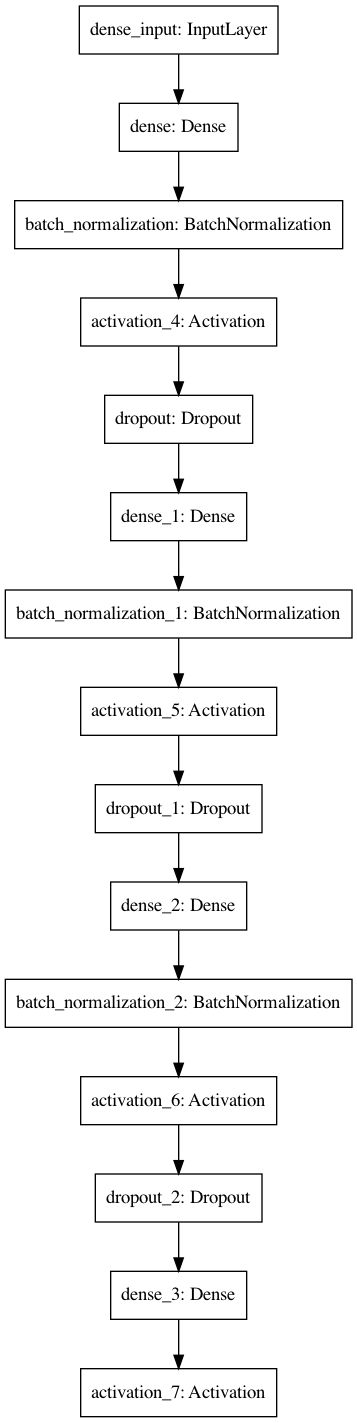

In [26]:
plot_model(w2v_dnn)

## Model Fitting

### Fitting using self-trained word embeddings

In [27]:
batch_size = 128
history =w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 10s 17ms/step - loss: 0.5071 - accuracy: 0.7677 - val_loss: 0.4319 - val_accuracy: 0.8289
Epoch 2/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3934 - accuracy: 0.8242 - val_loss: 0.3856 - val_accuracy: 0.8240
Epoch 3/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3675 - accuracy: 0.8375 - val_loss: 0.3663 - val_accuracy: 0.8400
Epoch 4/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3616 - accuracy: 0.8386 - val_loss: 0.3763 - val_accuracy: 0.8369
Epoch 5/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3531 - accuracy: 0.8485 - val_loss: 0.3745 - val_accuracy: 0.8294
Epoch 6/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3502 - accuracy: 0.8476 - val_loss: 0.4002 - val_accuracy: 0.8157
Epoch 7/10
247/247 [==============================] - 3s 10ms/step - loss: 0.3498 - accuracy: 0.8477 - val_loss: 0.3826 - val_accuracy: 0.825

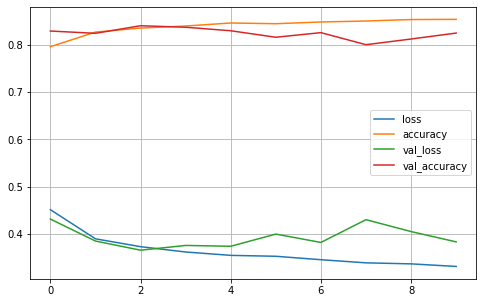

In [28]:
plot2(history)

In [29]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [30]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
from sklearn import metrics

In [31]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8216
Precision: 0.8253
Recall: 0.8216
F1 Score: 0.8211

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.87      0.83      7490
    positive       0.86      0.77      0.81      7510

    accuracy                           0.82     15000
   macro avg       0.83      0.82      0.82     15000
weighted avg       0.83      0.82      0.82     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   negative positive
Actual: negative       6548      942
        positive       1734     5776


### Fitting using pre-trained word embedding model

In [32]:
glove_dnn = construct_deepnn_architecture(num_input_features=96)

In [33]:
batch_size = 128
history2=glove_dnn.fit(train_glove_features, y_train, epochs=10, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 4s 11ms/step - loss: 0.7172 - accuracy: 0.6316 - val_loss: 0.6476 - val_accuracy: 0.6120
Epoch 2/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5890 - accuracy: 0.6921 - val_loss: 0.6032 - val_accuracy: 0.6734
Epoch 3/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5716 - accuracy: 0.7039 - val_loss: 0.5850 - val_accuracy: 0.6883
Epoch 4/10
247/247 [==============================] - 3s 11ms/step - loss: 0.5606 - accuracy: 0.7137 - val_loss: 0.6039 - val_accuracy: 0.6743
Epoch 5/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5480 - accuracy: 0.7221 - val_loss: 0.6082 - val_accuracy: 0.6817
Epoch 6/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5381 - accuracy: 0.7284 - val_loss: 0.5864 - val_accuracy: 0.6897
Epoch 7/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5367 - accuracy: 0.7302 - val_loss: 0.5882 - val_accuracy: 0.6957

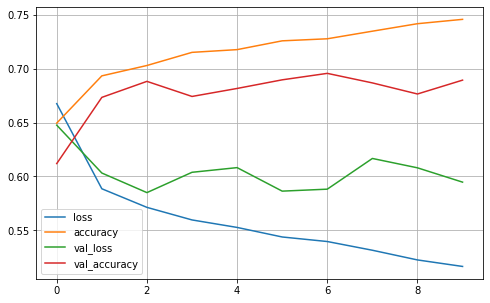

In [34]:
plot2(history2)

In [35]:
y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred) 

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])  

Model Performance metrics:
------------------------------
Accuracy: 0.7011
Precision: 0.7012
Recall: 0.7011
F1 Score: 0.701

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.69      0.70      7490
    positive       0.70      0.72      0.71      7510

    accuracy                           0.70     15000
   macro avg       0.70      0.70      0.70     15000
weighted avg       0.70      0.70      0.70     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   negative positive
Actual: negative       5134     2356
        positive       2128     5382


## References

- [State of Arts on this dataset](https://paperswithcode.com/sota/sentiment-analysis-on-imdb)